In [1]:
import sys

import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt


%matplotlib inline



# Background map with a box defined by latitude-longitude

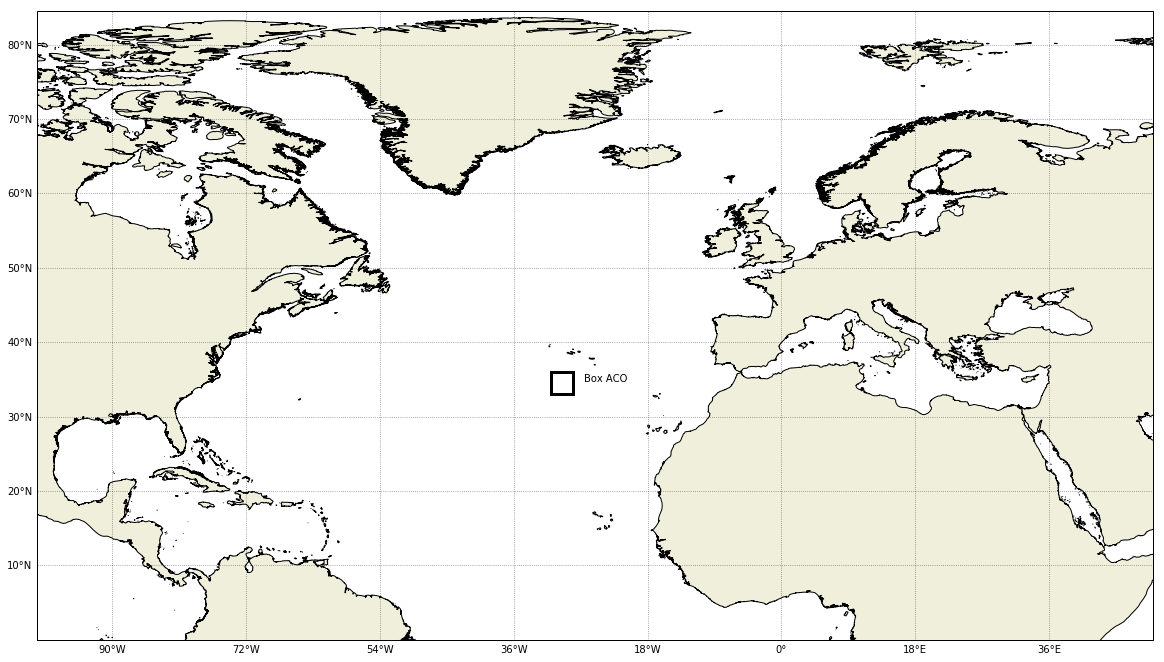

In [8]:
fig=plt.figure(figsize=(20,15))
ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent((-100, 50, 0, 70))
land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
ax.add_feature(land)
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.tick_params('both',labelsize=22)

ax.text(0.49, 0.41, 'Box ACO', transform=ax.transAxes)

ax.plot([-31, -28], [33, 33],color='black',linewidth=3)
ax.plot([-31, -28], [36, 36],color='black',linewidth=3)
ax.plot([-31, -31], [33, 36],color='black',linewidth=3)
ax.plot([-28, -28], [33, 36],color='black',linewidth=3)

# Computation of eke

In [ ]:
# u and v are not on the same grid that is why we shift
def compute_TKE(u,v):
    ua=0.5*(u*u+u.shift(x=-1)*u.shift(x=-1))
    va=0.5*(v*v+v.shift(y=-1)*v.shift(y=-1))
    eke=0.5*(uat+vat)
    return eke

In [ ]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
import zarr


In [ ]:
import time
import gcsfs


In [ ]:
%time

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
gcs = gcsfs.GCSFileSystem(gcs=fs,check=False,create=False)

mapzarru = gcs.get_mapper('pangeo-data/eNATL60-BLBT02-SSU-1h')
dsu = xr.open_zarr(mapzarru)

mapzarrv = gcs.get_mapper('pangeo-data/eNATL60-BLBT02-SSV-1h')
dsv = xr.open_zarr(mapzarrv)



In [ ]:
%%time
lat=dsu['nav_lat']
lon=dsu['nav_lon']
 
# definition of the area

latmin = 40.0; latmax = 41.0;
lonmin = -40.0; lonmax = -39.0;

domain = (lonmin<lon) * (lon<lonmax) * (latmin<lat) * (lat<latmax)
where = np.where(domain)

#get indice
jmin = np.min(where[0][:])
jmax = np.max(where[0][:])
imin = np.min(where[1][:])
imax = np.max(where[1][:])

latbox=lat[jmin:jmax,imin:imax]
lonbox=lon[jmin:jmax,imin:imax]


In [ ]:
%%time

print('Select dates')
u_JFM=dsu.sel(time_counter=slice('2010-01-01','2010-03-31'))['sozocrtx']
v_JFM=dsv.sel(time_counter=slice('2010-01-01','2010-03-31'))['somecrty']


print('Select box area')
u_JFM_box=u_JFM[:,jmin:jmax,imin:imax].chunk({'time_counter':10,'x':120,'y':120})
v_JFM_box=v_JFM[:,jmin:jmax,imin:imax].chunk({'time_counter':10,'x':120,'y':120})


In [ ]:
tke_JFM=compute_TKE(u_JFM,v_JFM)

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))

cmap = plt.get_cmap('cmo.amp')
ax.set_extent([-50, -30, 35, 45])
cmap.set_under(color='grey')
pcolor=ax.pcolormesh(lonbox,latbox,10000*ma.masked_invalid(tke_JFM),transform=ccrs.PlateCarree(),cmap=cmap,vmin=0,vmax=2500)
ax.add_feature(cfeature.LAND,facecolor='grey')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-50,-48,-46,-44,-42,-40,-38,-36,-34,-32,-30])
gl.ylocator = mticker.FixedLocator([35,36,37,38,39,40,41,42,43,44,45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.xlabels_top = False
gl.ylabels_left = False

cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label=unit)
ax.set_title('EKE JFM no filter',size=17,y=1.08)
 